<a href="https://colab.research.google.com/github/jajapuramshivasai/Portfolio_Optimization_QAOA/blob/main/portfolio_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portfolio Optimization Model

This notebook describes a portfolio optimization model with binary variables, linear constraints, and a quadratic objective.

---

## 1. Input Parameters

- **Securities $C$:**
  - $p_c$: Market price
  - $m_c$: Minimum trade
  - $M_c$: Maximum trade
  - $i_c$: Basket inventory
  - $\delta_c$: Minimum increment

- **Risk Buckets $L$:**
  - $K_\ell$: Bonds in bucket $\ell$ (not mutually exclusive)

- **Characteristics $J$:**
  - $K^{\text{target}}_{\ell, j}$: Target of characteristic $j$ in risk bucket $\ell$
  - $b^{\text{up}}_{\ell, j}$, $b^{\text{low}}_{\ell, j}$: Guardrails for characteristic $j$ in risk bucket $\ell$
  - $\beta_{c, j}$: Contribution of a unit of bond $c$ to the target of characteristic $j$
  - $K^{\text{up}}_{\ell, j}$, $K^{\text{low}}_{\ell, j}$: Guardrails for characteristic $j$ in risk bucket $\ell$ (binary version)

- **Global Parameters:**
  - $N$: Maximum number of bonds in portfolio
  - Minimum/maximum residual cash flow of portfolio

---

## 2. Decision Variables

- $y_c$: Binary variable indicating whether bond $c$ is included in the portfolio

> **Note:** The variable $x_c$ (how much of bond $c$ is included in the basket) is not a decision variable, but is fixed to the average value it is allowed to have if $c$ is included at all in the portfolio:
>
> $$x_c = \frac{m_c + \min(M_c, i_c)}{2 \delta_c} y_c$$

---

## 3. Constraints

- **Maximum Number of Bonds:**
  $$\sum_{c \in C} y_c \leq N$$

- **Residual Cash Flow:**
  $$\frac{\max RC}{MV^b} \leq \sum_{c \in C} \frac{p_c \delta_c x_c}{100 MV^b} \leq \frac{\min RC}{MV^b}$$

- **Min/Max Value of Each Characteristic $j$ in Each Risk Group $\ell$:**
  $$\sum_{c \in K_\ell} \frac{p_c \beta_{c, j} x_c}{100 MV^b} \leq b^{\text{up}}_{\ell, j}$$
  
  $$\sum_{c \in K_\ell} \frac{p_c \beta_{c, j} x_c}{100 MV^b} \geq b^{\text{low}}_{\ell, j}$$

- **Similar Constraints on the Binary Variable $y_c$:**
  $$\sum_{c \in K_\ell} \beta_{c, j} y_c \leq K^{\text{up}}_{\ell, j}, \quad \forall j \in J, \ell \in L$$
  
  $$\sum_{c \in K_\ell} \beta_{c, j} y_c \geq K^{\text{low}}_{\ell, j}, \quad \forall j \in J, \ell \in L$$

> *Constraints that guarantee consistency between $x_c$ and $y_c$ are not needed, since $x_c$ is not a variable in this model.*

---

## 4. Objective Function

Match the value of each characteristic $j$ in each risk group $\ell$ to its target (based on the quantity $x_c$ in the basket):

$$\min \sum_{\ell \in L} \sum_{j \in J} \rho_j \left( \sum_{c \in K_\ell} \beta_{c, j} x_c - K^{\text{target}}_{\ell, j} \right)^2$$

---

## 5. Summary Table

| Symbol | Description |
|--------|-------------|
| $p_c$ | Market price of bond $c$ |
| $m_c$ | Minimum trade of bond $c$ |
| $M_c$ | Maximum trade of bond $c$ |
| $i_c$ | Basket inventory of bond $c$ |
| $\delta_c$ | Minimum increment for bond $c$ |
| $y_c$ | Binary: is bond $c$ in the portfolio |
| $x_c$ | Quantity of bond $c$ (fixed if included) |
| $K_\ell$ | Bonds in risk bucket $\ell$ |
| $K^{\text{target}}_{\ell, j}$ | Target of characteristic $j$ in bucket $\ell$ |
| $b^{\text{up}}_{\ell, j}$, $b^{\text{low}}_{\ell, j}$ | Guardrails for characteristic $j$ in bucket $\ell$ |
| $\beta_{c, j}$ | Contribution of bond $c$ to characteristic $j$ |
| $K^{\text{up}}_{\ell, j}$, $K^{\text{low}}_{\ell, j}$ | Binary guardrails for characteristic $j$ in bucket $\ell$ |
| $N$ | Max number of bonds in portfolio |
| $MV^b$ | Market value of the basket |
| $\rho_j$ | Weight for characteristic $j$ in objective |
| $RC$ | Residual cash flow |

---




In [1]:
!pip install seaborn

In [ ]:
def prepare_qubo_data(df, found_columns):
    """Clean dataset and standardize column names for QUBO creation"""
    df_clean = df.copy()
    critical_columns = []
    for category in ['asset_id', 'price']:
        if found_columns[category]:
            critical_columns.extend(found_columns[category][:1])
    if critical_columns:
        df_clean = df_clean.dropna(subset=critical_columns)
        print(f"After removing missing critical data: {len(df_clean)} securities")
    column_mapping = {}
    if found_columns['asset_id']:
        column_mapping[found_columns['asset_id'][0]] = 'asset_id'
    if found_columns['price']:
        column_mapping[found_columns['price'][0]] = 'price'
    if found_columns['quantity']:
        column_mapping[found_columns['quantity'][0]] = 'current_position'
    if found_columns['benchmark_weight']:
        column_mapping[found_columns['benchmark_weight'][0]] = 'benchmark_weight'
    if found_columns['duration']:
        column_mapping[found_columns['duration'][0]] = 'duration'
    df_clean = df_clean.rename(columns=column_mapping)
    print(f"Column mapping applied: {column_mapping}")
    print(f"Final dataset shape: {df_clean.shape}")
    return df_clean


In [ ]:
def create_objective_matrix(df, penalty_weights, max_assets):
    n_assets = len(df)
    Q = np.zeros((n_assets, n_assets))
    linear_terms = np.zeros(n_assets)
    # Tracking error penalty
    if 'benchmark_weight' in df.columns:
        bw = df['benchmark_weight'].fillna(0).values
        if bw.sum() > 0:
            bw = bw / bw.sum()
        for i in range(n_assets):
            linear_terms[i] += penalty_weights['tracking_error'] * (-2 * bw[i])
            Q[i, i] += penalty_weights['tracking_error']
    # Diversification penalty
    diversification_penalty = 10.0
    for i in range(n_assets):
        for j in range(n_assets):
            if i != j:
                Q[i, j] += diversification_penalty
    # Budget penalty
    for i in range(n_assets):
        linear_terms[i] += penalty_weights['budget'] * (-2 * max_assets)
        for j in range(n_assets):
            Q[i, j] += penalty_weights['budget']
    return Q, linear_terms

def add_risk_constraints(Q, linear_terms, df, penalty_weights, max_assets):
    n_assets = len(df)
    # Duration constraint
    if 'duration' in df.columns:
        durations = df['duration'].fillna(0).values
        target = np.mean(durations[durations > 0])
        dur_penalty = penalty_weights['risk_limits']*0.1
        for i in range(n_assets):
            for j in range(n_assets):
                Q[i, j] += dur_penalty * (durations[i]-target)*(durations[j]-target)
    # Credit quality constraint
    if 'credit_rating' in df.columns:
        risky = df['credit_rating'].isin(['BB','B','CCC','CC','C','D'])
        risky_idx = df[risky].index.tolist()
        max_risky = int(max_assets * 0.1)
        risk_penalty = penalty_weights['risk_limits']*0.3
        for i in risky_idx:
            linear_terms[i] += risk_penalty * (-2 * max_risky)
            for j in risky_idx:
                Q[i, j] += risk_penalty
    return Q, linear_terms

def add_practical_constraints(Q, linear_terms, df, penalty_weights):
    if 'price' in df.columns:
        prices = df['price'].fillna(100).values
        min_val = 1_000_000
        small_penalty = penalty_weights['turnover']
        for i in range(len(df)):
            if prices[i] * 1000 < min_val:
                linear_terms[i] += small_penalty * 0.1
    return Q, linear_terms

def formulate_complete_qubo(df):
    penalty_weights = {
        'tracking_error': 1000.0,
        'risk_limits': 500.0,
        'budget': 2000.0,
        'turnover': 100.0
    }
    max_assets = min(31, len(df)//4)
    Q, lin = create_objective_matrix(df, penalty_weights, max_assets)
    Q, lin = add_risk_constraints(Q, lin, df, penalty_weights, max_assets)
    Q, lin = add_practical_constraints(Q, lin, df, penalty_weights)
    Q = (Q + Q.T) / 2
    return Q, lin, max_assets


In [ ]:
# === INSTALL DEPENDENCIES ===
# (Uncomment if running in Colab or a fresh environment)
# !pip install matplotlib seaborn pandas numpy scikit-learn

import pandas as pd
import numpy as np
import logging

# ---------------------------------
# TASK 1: DATA LOADING & INSPECTION
# ---------------------------------

def load_vanguard_data(filepath="data_assets_dump_partial.xlsx"):
    """Load and inspect the Vanguard bond dataset"""
    excel_file = pd.ExcelFile(filepath)
    print("Available sheets:", excel_file.sheet_names)

    df = pd.read_excel(filepath, sheet_name=0)
    print(f"\nDataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print("\nFirst few rows:\n", df.head())
    print("\nData types:\n", df.dtypes)
    print("\nMissing values:\n", df.isnull().sum())
    return df

def analyze_data_structure(df):
    """Identify key columns by scanning for known patterns."""
    key_columns = {
        'asset_id': ['assetId', 'asset_id', 'id', 'cusip', 'isin'],
        'price': ['price', 'market_price', 'clean_price', 'dirty_price'],
        'quantity': ['quantity', 'position', 'holdings', 'notional'],
        'benchmark_weight': ['benchmark', 'bench', 'target_weight', 'index_weight'],
        'duration': ['duration', 'oad', 'modified_duration', 'eff_duration'],
        'credit_rating': ['rating', 'credit', 'quality', 'grade'],
        'sector': ['sector', 'industry', 'gics', 'classification']
    }

    found_columns = {}
    for category, possible_names in key_columns.items():
        found = []
        for col in df.columns:
            for possible in possible_names:
                if possible.lower() in col.lower():
                    found.append(col)
        found_columns[category] = list(set(found))

    print("\nIdentified key columns:")
    for category, columns in found_columns.items():
        print(f" {category}: {columns}")
    return found_columns

# ---------------------------------
# TASK 2: QUBO PREPARATION
# ---------------------------------

def prepare_qubo_data(df, found_columns):
    """Drop missing values for critical fields and standardize names."""
    df_clean = df.copy()
    critical_columns = []
    for category in ['asset_id', 'price']:
        if found_columns[category]:
            critical_columns.extend(found_columns[category][:1])
    if critical_columns:
        df_clean = df_clean.dropna(subset=critical_columns)
        print(f"After removing missing critical data: {len(df_clean)} securities")

    column_mapping = {}
    if found_columns['asset_id']:
        column_mapping[found_columns['asset_id'][0]] = 'asset_id'
    if found_columns['price']:
        column_mapping[found_columns['price'][0]] = 'price'
    if found_columns['quantity']:
        column_mapping[found_columns['quantity'][0]] = 'current_position'
    if found_columns['benchmark_weight']:
        column_mapping[found_columns['benchmark_weight'][0]] = 'benchmark_weight'
    if found_columns['duration']:
        column_mapping[found_columns['duration'][0]] = 'duration'

    df_clean = df_clean.rename(columns=column_mapping)
    print(f"Column mapping applied: {column_mapping}")
    print(f"Final dataset shape: {df_clean.shape}")
    return df_clean

# ---------------------------------
# QUBO CONSTRUCTION FUNCTIONS
# ---------------------------------

def create_objective_matrix(df, penalty_weights, max_assets):
    """Base quadratic objective: tracking error + diversification + budget"""
    n_assets = len(df)
    Q = np.zeros((n_assets, n_assets))
    linear_terms = np.zeros(n_assets)

    # Tracking error penalty
    if 'benchmark_weight' in df.columns:
        bw = df['benchmark_weight'].fillna(0).values
        if bw.sum() > 0:
            bw = bw / bw.sum()
        for i in range(n_assets):
            linear_terms[i] += penalty_weights['tracking_error'] * (-2 * bw[i])
            Q[i, i] += penalty_weights['tracking_error']

    # Diversification (penalize off-diagonal)
    diversification_penalty = 10.0
    for i in range(n_assets):
        for j in range(n_assets):
            if i != j:
                Q[i, j] += diversification_penalty

    # Budget constraint penalty
    for i in range(n_assets):
        linear_terms[i] += penalty_weights['budget'] * (-2 * max_assets)
        for j in range(n_assets):
            Q[i, j] += penalty_weights['budget']

    return Q, linear_terms

def add_risk_constraints(Q, linear_terms, df, penalty_weights, max_assets):
    """Add duration and credit quality constraints"""
    n_assets = len(df)
    if 'duration' in df.columns:
        durations = df['duration'].fillna(0).values
        target = np.mean(durations[durations > 0])
        dur_penalty = penalty_weights['risk_limits'] * 0.1
        for i in range(n_assets):
            for j in range(n_assets):
                Q[i, j] += dur_penalty * (durations[i] - target) * (durations[j] - target)

    if 'credit_rating' in df.columns:
        risky = df['credit_rating'].isin(['BB', 'B', 'CCC', 'CC', 'C', 'D'])
        risky_idx = df[risky].index.tolist()
        max_risky = int(max_assets * 0.1)
        risk_penalty = penalty_weights['risk_limits'] * 0.3
        for i in risky_idx:
            linear_terms[i] += risk_penalty * (-2 * max_risky)
            for j in risky_idx:
                Q[i, j] += risk_penalty
    return Q, linear_terms

def add_practical_constraints(Q, linear_terms, df, penalty_weights):
    """Add minimum trade size & liquidity constraints"""
    if 'price' in df.columns:
        prices = df['price'].fillna(100).values
        min_val = 1_000_000
        small_penalty = penalty_weights['turnover']
        for i in range(len(df)):
            if prices[i] * 1000 < min_val:
                linear_terms[i] += small_penalty * 0.1
    return Q, linear_terms

def formulate_complete_qubo(df):
    """Full QUBO build = objective + constraints"""
    penalty_weights = {
        'tracking_error': 1000.0,
        'risk_limits': 500.0,
        'budget': 2000.0,
        'turnover': 100.0
    }
    max_assets = min(31, len(df) // 4)
    Q, lin = create_objective_matrix(df, penalty_weights, max_assets)
    Q, lin = add_risk_constraints(Q, lin, df, penalty_weights, max_assets)
    Q, lin = add_practical_constraints(Q, lin, df, penalty_weights)
    Q = (Q + Q.T) / 2  # Symmetrize for QUBO
    return Q, lin, max_assets

# ---------------------------------
# TASK 4: CLASSICAL SOLVER
# ---------------------------------

def solve_classical_approximation(Q, linear_terms, max_assets):
    """Greedy + random sampling; pick better"""
    n = len(linear_terms)
    scores = linear_terms + np.diag(Q)
    idx = np.argsort(scores)[:max_assets]
    greedy_sol = np.zeros(n, dtype=int)
    greedy_sol[idx] = 1
    greedy_obj = greedy_sol @ linear_terms + greedy_sol @ Q @ greedy_sol

    best_sol = greedy_sol.copy()
    best_obj = greedy_obj

    for _ in range(1000):
        cand_idx = np.random.choice(n, max_assets, replace=False)
        sol = np.zeros(n, dtype=int)
        sol[cand_idx] = 1
        obj = sol @ linear_terms + sol @ Q @ sol
        if obj < best_obj:
            best_obj = obj
            best_sol = sol.copy()
    method = "random_sampling" if best_obj < greedy_obj else "greedy"
    return best_sol, best_obj, method

# ---------------------------------
# TASK 5: RESULT ANALYSIS
# ---------------------------------

def analyze_solution(solution, df):
    sel_idx = np.where(solution == 1)[0]
    sel_df = df.iloc[sel_idx]
    print(f"\nSelected {len(sel_idx)} assets")
    if 'price' in sel_df.columns:
        print(f"Total value: ${sel_df['price'].sum():,.0f}")
    if 'duration' in sel_df.columns:
        print(f"Average duration: {sel_df['duration'].mean():.2f}")
    return sel_df

# ---------------------------------
# MAIN EXECUTION
# ---------------------------------

def main():
    df = load_vanguard_data()
    found_cols = analyze_data_structure(df)
    df_clean = prepare_qubo_data(df, found_cols).head(16)  # small subset for demo
    Q, lin, max_assets = formulate_complete_qubo(df_clean)
    sol, obj, method = solve_classical_approximation(Q, lin, max_assets)
    print(f"\nSOLUTION FOUND using {method} with objective {obj:.2f}")
    sel_df = analyze_solution(sol, df_clean)
    return Q, lin, sol, sel_df

if __name__ == "__main__":
    Q, lin, sol, sel_df = main()


#end

In [7]:
import pandas as pd
import numpy as np
import logging

def load_vanguard_data():
    data_file = "data_assets_dump_partial.xlsx"
    try:
        excel_file = pd.ExcelFile(data_file)
        print("Available sheets:", excel_file.sheet_names)
        df = pd.read_excel(data_file, sheet_name=0)
        print(f"\nDataset shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        print(f"\nFirst few rows:")
        print(df.head())
        print(f"\nData types:")
        print(df.dtypes)
        print(f"\nMissing values:")
        print(df.isnull().sum())
        return df
    except Exception as e:
        logging.error(f"Error loading data: {e}")
        raise

def analyze_data_structure(df):
    key_columns = {
        'asset_id': ['assetId', 'asset_id', 'id', 'cusip', 'isin'],
        'price': ['price', 'market_price', 'clean_price', 'dirty_price'],
        'quantity': ['quantity', 'position', 'holdings', 'notional'],
        'benchmark_weight': ['benchmark', 'bench', 'target_weight', 'index_weight'],
        'duration': ['duration', 'oad', 'modified_duration', 'eff_duration'],
        'credit_rating': ['rating', 'credit', 'quality', 'grade'],
        'sector': ['sector', 'industry', 'gics', 'classification']
    }
    found_columns = {}
    for category, possible_names in key_columns.items():
        found = []
        for col in df.columns:
            for possible in possible_names:
                if possible.lower() in col.lower():
                    found.append(col)
        found_columns[category] = list(set(found))
    print("\nIdentified key columns:")
    for category, columns in found_columns.items():
        print(f"  {category}: {columns}")
    return found_columns

def prepare_qubo_data(df, found_columns):
    df_clean = df.copy()
    critical_columns = []
    for category in ['asset_id', 'price']:
        if found_columns[category]:
            critical_columns.extend(found_columns[category][:1])
    if critical_columns:
        df_clean = df_clean.dropna(subset=critical_columns)
        print(f"After removing missing critical data: {len(df_clean)} securities")
    column_mapping = {}
    if found_columns['asset_id']:
        column_mapping[found_columns['asset_id'][0]] = 'asset_id'
    if found_columns['price']:
        column_mapping[found_columns['price'][0]] = 'price'
    if found_columns['quantity']:
        column_mapping[found_columns['quantity'][0]] = 'current_position'
    if found_columns['benchmark_weight']:
        column_mapping[found_columns['benchmark_weight'][0]] = 'benchmark_weight'
    if found_columns['duration']:
        column_mapping[found_columns['duration'][0]] = 'duration'
    df_clean = df_clean.rename(columns=column_mapping)
    print(f"Column mapping applied: {column_mapping}")
    print(f"Final dataset shape: {df_clean.shape}")
    return df_clean

def create_objective_matrix(df, penalty_weights, max_assets):
    n_assets = len(df)
    Q = np.zeros((n_assets, n_assets))
    linear_terms = np.zeros(n_assets)
    if 'benchmark_weight' in df.columns:
        benchmark_weights = df['benchmark_weight'].fillna(0).values
        if benchmark_weights.sum() > 0:
            benchmark_weights = benchmark_weights / benchmark_weights.sum()
        for i in range(n_assets):
            linear_terms[i] += penalty_weights['tracking_error'] * (-2 * benchmark_weights[i])
            Q[i, i] += penalty_weights['tracking_error']
    concentration_penalty = 10.0
    for i in range(n_assets):
        for j in range(n_assets):
            if i != j:
                Q[i, j] += concentration_penalty
    budget_target = max_assets
    for i in range(n_assets):
        linear_terms[i] += penalty_weights['budget'] * (-2 * budget_target)
        for j in range(n_assets):
            Q[i, j] += penalty_weights['budget']
    return Q, linear_terms

def add_risk_constraints(Q, linear_terms, df, penalty_weights, max_assets):
    n_assets = len(df)
    if 'duration' in df.columns:
        durations = df['duration'].fillna(0).values
        target_duration = np.mean(durations[durations > 0])
        if target_duration > 0:
            duration_penalty = penalty_weights['risk_limits'] * 0.1
            for i in range(n_assets):
                duration_dev_i = durations[i] - target_duration
                for j in range(n_assets):
                    duration_dev_j = durations[j] - target_duration
                    Q[i, j] += duration_penalty * duration_dev_i * duration_dev_j
    if 'sector' in df.columns:
        sectors = df['sector'].fillna('Other')
        unique_sectors = sectors.unique()
        sector_limit = 0.3
        max_assets_per_sector = int(max_assets * sector_limit)
        sector_penalty = penalty_weights['risk_limits'] * 0.2
        for sector in unique_sectors:
            sector_assets = df[df['sector'] == sector].index.tolist()
            if len(sector_assets) > max_assets_per_sector:
                for i in sector_assets:
                    linear_terms[i] += sector_penalty * (-2 * max_assets_per_sector)
                    for j in sector_assets:
                        Q[i, j] += sector_penalty
    if 'credit_rating' in df.columns:
        ratings = df['credit_rating'].fillna('NR')
        high_risk_ratings = ['BB', 'B', 'CCC', 'CC', 'C', 'D']
        high_risk_mask = ratings.isin(high_risk_ratings)
        if high_risk_mask.sum() > 0:
            high_risk_penalty = penalty_weights['risk_limits'] * 0.3
            high_risk_indices = df[high_risk_mask].index.tolist()
            max_high_risk = int(max_assets * 0.1)
            for i in high_risk_indices:
                linear_terms[i] += high_risk_penalty * (-2 * max_high_risk)
                for j in high_risk_indices:
                    Q[i, j] += high_risk_penalty
    return Q, linear_terms

def add_practical_constraints(Q, linear_terms, df, penalty_weights, max_assets):
    n_assets = len(df)
    if 'price' in df.columns:
        prices = df['price'].fillna(100).values
        min_position_value = 1000000
        small_position_penalty = penalty_weights['turnover']
        for i in range(n_assets):
            if prices[i] > 0:
                if prices[i] * 1000 < min_position_value:
                    linear_terms[i] += small_position_penalty * 0.1
    missing_price_penalty = penalty_weights['turnover'] * 0.5
    for i in range(n_assets):
        if 'price' in df.columns:
            if pd.isna(df.iloc[i]['price']) or df.iloc[i]['price'] <= 0:
                linear_terms[i] += missing_price_penalty
    return Q, linear_terms

def formulate_complete_qubo(df):
    n_assets = len(df)
    penalty_weights = {
        'tracking_error': 1000.0,
        'risk_limits': 500.0,
        'budget': 2000.0,
        'turnover': 100.0
    }
    max_assets = min(31, n_assets // 4)
    Q, linear_terms = create_objective_matrix(df, penalty_weights, max_assets)
    Q, linear_terms = add_risk_constraints(Q, linear_terms, df, penalty_weights, max_assets)
    Q, linear_terms = add_practical_constraints(Q, linear_terms, df, penalty_weights, max_assets)
    Q = (Q + Q.T) / 2
    return Q, linear_terms, max_assets

def solve_classical_approximation(Q, linear_terms, max_assets):
    n_assets = len(linear_terms)
    asset_scores = linear_terms.copy()
    for i in range(len(asset_scores)):
        asset_scores[i] += Q[i, i]
    sorted_indices = np.argsort(asset_scores)
    selected_assets = sorted_indices[:max_assets]
    solution_greedy = np.zeros(n_assets, dtype=int)
    solution_greedy[selected_assets] = 1
    obj_value_greedy = (
        np.dot(solution_greedy, linear_terms) +
        np.dot(solution_greedy, np.dot(Q, solution_greedy))
    )
    best_solution = None
    best_objective = float('inf')
    n_samples = 1000
    for _ in range(n_samples):
        random_indices = np.random.choice(n_assets, max_assets, replace=False)
        solution = np.zeros(n_assets, dtype=int)
        solution[random_indices] = 1
        obj_value = (
            np.dot(solution, linear_terms) +
            np.dot(solution, np.dot(Q, solution))
        )
        if obj_value < best_objective:
            best_objective = obj_value
            best_solution = solution.copy()
    if best_objective < obj_value_greedy:
        return best_solution, best_objective, "random_sampling"
    else:
        return solution_greedy, obj_value_greedy, "greedy"

def analyze_solution(solution, df):
    selected_indices = np.where(solution == 1)[0]
    selected_df = df.iloc[selected_indices].copy()
    print(f"\nSelected {len(selected_indices)} assets:")
    # Additional summary stats as desired...
    return selected_df

def main():
    df = load_vanguard_data()
    found_columns = analyze_data_structure(df)
    df_clean = prepare_qubo_data(df, found_columns).head(8)   #This is to change number of data points
    Q, linear_terms, max_assets = formulate_complete_qubo(df_clean)
    solution, obj_value, method = solve_classical_approximation(Q, linear_terms, max_assets)
    selected_portfolio = analyze_solution(solution, df_clean)
    print(f"\nSOLUTION FOUND using {method}")
    print(f"Objective value: {obj_value:.2f}")
    return Q, linear_terms, solution, df_clean



In [8]:
Q, linear_terms, solution, df_clean = main()
print(solution)

Available sheets: ['Sheet1']

Dataset shape: (2629, 278)
Columns: ['Unnamed: 0', 'isin', 'ccy', 'assetId', 'strategyName', 'secGroup', 'secType', 'cpn', 'posSource', 'baseCcy', 'krd10y', 'krd15y', 'krd20y', 'krd25y', 'krd30y', 'krd1y', 'krd2y', 'krd3m', 'krd3y', 'krd40y', 'krd50y', 'krd5y', 'krd7y', 'oad', 'oas', 'spreadDur', 'issuerCountry', 'countryRisk', 'issuerId', 'issuerLongName', 'issuerShortName', 'issuerTicker', 'portfolioName', 'fund_posQuantity', 'maturity', 'minTradeIncrement', 'minTradeSize', 'fund_orderStatus', 'fund_enriched.mktValue', 'fund_enriched.notionalMktValue', 'enriched.cashladder_tCashBalance', 'enriched.cashladder_tPlus1CashBalance', 'enriched.cashladder_tPlus2CashBalance', 'enriched.cashladder_tPlus3CashBalance', 'enriched.cashladder_tPlus4CashBalance', 'enriched.cashladder_tPlus5CashBalance', 'enriched.cashladder_tPlus6CashBalance', 'enriched.cashladder_tPlus7CashBalance', 'enriched.cashladder_tPlus30CashBalance', 'enriched.cashladder_tPlus60CashBalance', 'e

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 98.1 MB/s eta 0:00:00
Graph: 4 nodes, 5 edges


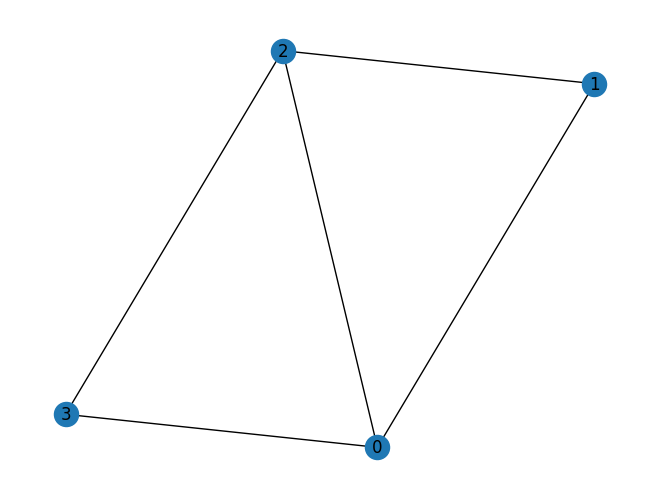

Step   0 | Energy = -2.495014
Step  10 | Energy = -3.085395
Step  20 | Energy = -3.324295
Step  30 | Energy = -3.439939
Step  40 | Energy = -3.445827
Step  50 | Energy = -3.452728
Step  60 | Energy = -3.454020
Step  70 | Energy = -3.456650
Step  80 | Energy = -3.457057
Step  90 | Energy = -3.457142
Optimized parameters: [-0.25851704 -0.56070176  0.39087633  0.19917152]
Most common results: [('1010', 242), ('0101', 227), ('1100', 89), ('1001', 75), ('0011', 75)]


In [3]:
# ==========================
# 1) Install required libs
# ==========================
!pip install pennylane networkx matplotlib

# ==========================
# 2) Imports
# ==========================
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# ==========================
# 3) Define Max-Cut problem
# ==========================
# Example graph
G = nx.Graph()
G.add_edges_from([(0,1), (1,2), (2,3), (3,0), (0,2)])
n = G.number_of_nodes()
print(f"Graph: {n} nodes, {G.number_of_edges()} edges")

# Draw the graph
nx.draw(G, with_labels=True)
plt.show()

# ==========================
# 4) Build cost Hamiltonian
# ==========================
edges = list(G.edges())

def cost_hamiltonian(gamma):
    for (i, j) in edges:
        qml.CNOT(wires=[i, j])
        qml.RZ(2 * gamma, wires=j)
        qml.CNOT(wires=[i, j])

def mixer_hamiltonian(beta):
    for i in range(n):
        qml.RX(2 * beta, wires=i)

# ==========================
# 5) QAOA circuit
# ==========================
p = 2  # QAOA depth
dev = qml.device("default.qubit", wires=n, shots=None)

@qml.qnode(dev)
def qaoa_circuit(params):
    # Initial state: Hadamard on all qubits
    for i in range(n):
        qml.Hadamard(wires=i)

    gammas = params[:p]
    betas = params[p:]

    for layer in range(p):
        cost_hamiltonian(gammas[layer])
        mixer_hamiltonian(betas[layer])

    return qml.expval(cost)

# ==========================
# 6) Cost function for Max-Cut
# ==========================
coeffs = []
obs = []
for (i, j) in edges:
    coeffs.append(0.5)
    obs.append(qml.PauliZ(i) @ qml.PauliZ(j))
    coeffs.append(-0.5)
    obs.append(qml.Identity(0))

cost = qml.Hamiltonian(coeffs, obs)

def cost_fn(params):
    return qaoa_circuit(params)

# ==========================
# 7) Optimize parameters
# ==========================
params = 0.01 * np.random.randn(2 * p, requires_grad=True)
opt = qml.optimize.AdamOptimizer(stepsize=0.1)

steps = 100
for step in range(steps):
    params, energy = opt.step_and_cost(cost_fn, params)
    if step % 10 == 0:
        print(f"Step {step:3d} | Energy = {energy:.6f}")

print("Optimized parameters:", params)

# ==========================
# 8) Get best bitstring
# ==========================
dev_samples = qml.device("default.qubit", wires=n, shots=1000)

@qml.qnode(dev_samples)
def sampled_qaoa(params):
    # Same as before but sample
    for i in range(n):
        qml.Hadamard(wires=i)
    gammas = params[:p]
    betas = params[p:]
    for layer in range(p):
        cost_hamiltonian(gammas[layer])
        mixer_hamiltonian(betas[layer])
    return qml.sample(wires=range(n))

samples = sampled_qaoa(params)
# Convert samples to bitstrings
bitstrings = ["".join(str(int(b)) for b in s) for s in samples]
from collections import Counter
counts = Counter(bitstrings)
print("Most common results:", counts.most_common(5))


Required installation:
pip install pennylane matplotlib

Step 1: Testing on small QUBO...
TESTING PENNYLANE QAOA ON SMALL QUBO
Test QUBO matrix:
[[ 2.  -1.   0.   0.5]
 [-1.   3.  -1.   0. ]
 [ 0.  -1.   2.  -0.5]
 [ 0.5  0.  -0.5  1. ]]
PennyLane QAOA Solver initialized:
  - Problem size: 4 qubits
  - QAOA layers: 2
  - Backend: default.qubit
  - Shots: 1024
Starting PennyLane QAOA optimization...
  - Optimizer: COBYLA
  - Max iterations: 30
Running classical optimization...
Optimization completed!
  - Success: False
  - Iterations: 30
  - Final cost: -8.9023

PENNYLANE QAOA SOLUTION ANALYSIS
Best solution: [0 0 0 0]
Objective value: 0.0000
Selected qubits: []
Number selected: 0

Top 5 solutions found:
  1. [0 0 0 0] | Prob: 0.001 | Obj: 0.00
  2. [0 0 0 1] | Prob: 0.016 | Obj: 1.00
  3. [0 0 1 1] | Prob: 0.005 | Obj: 2.00
  4. [1 0 0 0] | Prob: 0.001 | Obj: 2.00
  5. [0 1 0 0] | Prob: 0.001 | Obj: 3.00


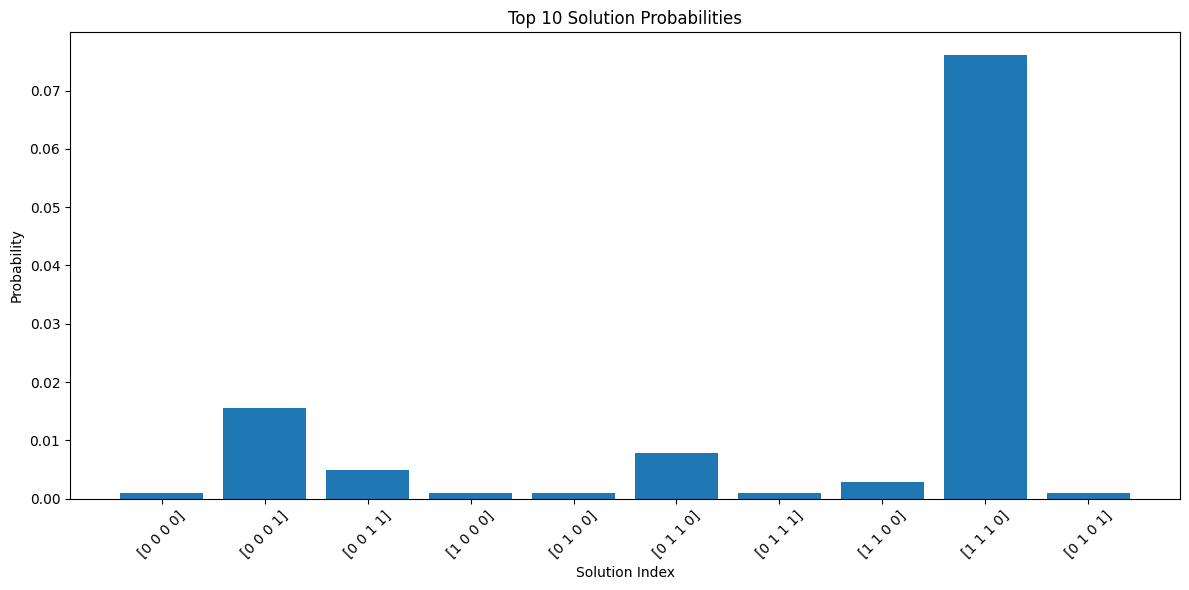



Step 2: Portfolio optimization...
PORTFOLIO OPTIMIZATION WITH PENNYLANE QAOA
Available sheets: ['Sheet1']

Dataset shape: (2629, 278)
Columns: ['Unnamed: 0', 'isin', 'ccy', 'assetId', 'strategyName', 'secGroup', 'secType', 'cpn', 'posSource', 'baseCcy', 'krd10y', 'krd15y', 'krd20y', 'krd25y', 'krd30y', 'krd1y', 'krd2y', 'krd3m', 'krd3y', 'krd40y', 'krd50y', 'krd5y', 'krd7y', 'oad', 'oas', 'spreadDur', 'issuerCountry', 'countryRisk', 'issuerId', 'issuerLongName', 'issuerShortName', 'issuerTicker', 'portfolioName', 'fund_posQuantity', 'maturity', 'minTradeIncrement', 'minTradeSize', 'fund_orderStatus', 'fund_enriched.mktValue', 'fund_enriched.notionalMktValue', 'enriched.cashladder_tCashBalance', 'enriched.cashladder_tPlus1CashBalance', 'enriched.cashladder_tPlus2CashBalance', 'enriched.cashladder_tPlus3CashBalance', 'enriched.cashladder_tPlus4CashBalance', 'enriched.cashladder_tPlus5CashBalance', 'enriched.cashladder_tPlus6CashBalance', 'enriched.cashladder_tPlus7CashBalance', 'enrich

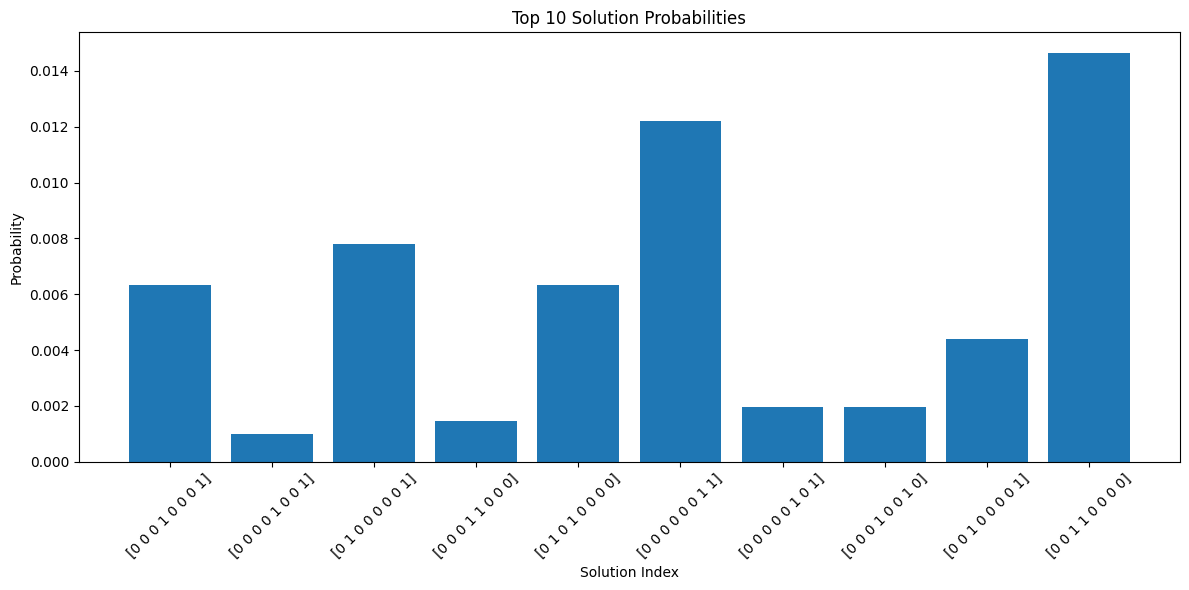


SELECTED PORTFOLIO ANALYSIS
Selected 2 assets:
  1. 2022-05-18T00:00:00.000Z | Price: $100.0679183333333
  2. 2021-08-18T00:00:00.000Z | Price: $85.01568

Total portfolio value: $185

PENNYLANE QAOA OPTIMIZATION COMPLETE!


In [9]:
import numpy as np
import pandas as pd
import pennylane as qml
from pennylane import numpy as pnp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def qubo_to_pennylane_hamiltonian(Q):
    """Convert QUBO matrix to PennyLane Hamiltonian"""
    n = Q.shape[0]

    # Create Hamiltonian terms
    coeffs = []
    ops = []

    # Linear terms (diagonal elements)
    for i in range(n):
        if Q[i, i] != 0:
            coeffs.append(Q[i, i])
            ops.append(qml.PauliZ(i))

    # Quadratic terms (off-diagonal elements)
    for i in range(n):
        for j in range(i + 1, n):
            if Q[i, j] != 0:
                coeffs.append(Q[i, j])
                ops.append(qml.PauliZ(i) @ qml.PauliZ(j))

    # Create Hamiltonian
    if coeffs:
        H = qml.Hamiltonian(coeffs, ops)
    else:
        # Empty Hamiltonian case
        H = qml.Hamiltonian([0.0], [qml.Identity(0)])

    return H

class PennyLaneQAOASolver:
    """QAOA solver using PennyLane for QUBO problems"""

    def __init__(self, Q, layers=6, shots=1024, backend='default.qubit'):
        self.Q = Q
        self.n_qubits = Q.shape[0]
        self.layers = layers
        self.shots = shots

        # Create Hamiltonian
        self.cost_hamiltonian = qubo_to_pennylane_hamiltonian(Q)

        # Set up device
        self.dev = qml.device(backend, wires=self.n_qubits, shots=shots)

        print(f"PennyLane QAOA Solver initialized:")
        print(f"  - Problem size: {self.n_qubits} qubits")
        print(f"  - QAOA layers: {self.layers}")
        print(f"  - Backend: {backend}")
        print(f"  - Shots: {shots}")

    def qaoa_circuit(self, params):
        """QAOA circuit implementation"""
        # Extract parameters
        gammas = params[:self.layers]
        betas = params[self.layers:]

        # Initial state: equal superposition
        for i in range(self.n_qubits):
            qml.Hadamard(wires=i)

        # QAOA layers
        for layer in range(self.layers):
            # Cost layer (problem Hamiltonian)
            qml.ApproxTimeEvolution(self.cost_hamiltonian, gammas[layer], 1)

            # Mixer layer (X rotations)
            for i in range(self.n_qubits):
                qml.RX(2 * betas[layer], wires=i)

    def create_cost_function(self):
        """Create cost function for classical optimization"""

        @qml.qnode(self.dev)
        def cost_circuit(params):
            self.qaoa_circuit(params)
            return qml.expval(self.cost_hamiltonian)

        return cost_circuit

    def create_sampling_function(self):
        """Create sampling function to get measurement results"""

        @qml.qnode(self.dev)
        def sampling_circuit(params):
            self.qaoa_circuit(params)
            return qml.sample()

        return sampling_circuit

    def evaluate_bitstring(self, bitstring):
        """Evaluate QUBO objective for a given bitstring"""
        x = np.array(bitstring, dtype=int)
        return x.T @ self.Q @ x

    def solve(self, maxiter=100, method='COBYLA'):
        """Solve QUBO using QAOA"""

        print(f"Starting PennyLane QAOA optimization...")
        print(f"  - Optimizer: {method}")
        print(f"  - Max iterations: {maxiter}")

        # Create cost function
        cost_fn = self.create_cost_function()

        # Random initial parameters
        init_params = np.random.uniform(0, 2*np.pi, 2 * self.layers)

        # Classical optimization
        print("Running classical optimization...")
        if method == 'COBYLA':
            opt_result = minimize(cost_fn, init_params, method='COBYLA',
                                options={'maxiter': maxiter})
        else:
            opt_result = minimize(cost_fn, init_params, method=method,
                                options={'maxiter': maxiter})

        print(f"Optimization completed!")
        print(f"  - Success: {opt_result.success}")
        print(f"  - Iterations: {opt_result.nfev}")
        print(f"  - Final cost: {opt_result.fun:.4f}")

        # Get final samples
        sampling_fn = self.create_sampling_function()
        samples = sampling_fn(opt_result.x)

        # Process samples
        unique_samples, counts = np.unique(samples, axis=0, return_counts=True)

        # Find best solution
        best_objective = float('inf')
        best_solution = None

        results = []
        for sample, count in zip(unique_samples, counts):
            obj_val = self.evaluate_bitstring(sample)
            prob = count / len(samples)
            results.append({
                'bitstring': sample,
                'count': count,
                'probability': prob,
                'objective': obj_val
            })

            if obj_val < best_objective:
                best_objective = obj_val
                best_solution = sample

        # Sort results by objective value
        results.sort(key=lambda x: x['objective'])

        return {
            'solution': best_solution,
            'objective_value': best_objective,
            'optimization_result': opt_result,
            'all_results': results,
            'samples': samples
        }

    def analyze_results(self, result):
        """Analyze and display results"""
        print("\n" + "="*60)
        print("PENNYLANE QAOA SOLUTION ANALYSIS")
        print("="*60)

        print(f"Best solution: {result['solution']}")
        print(f"Objective value: {result['objective_value']:.4f}")
        print(f"Selected qubits: {np.where(result['solution'] == 1)[0]}")
        print(f"Number selected: {np.sum(result['solution'])}")

        print(f"\nTop 5 solutions found:")
        for i, res in enumerate(result['all_results'][:5]):
            print(f"  {i+1}. {res['bitstring']} | "
                  f"Prob: {res['probability']:.3f} | "
                  f"Obj: {res['objective']:.2f}")

        # Plot probability distribution
        if len(result['all_results']) > 1:
            probs = [res['probability'] for res in result['all_results'][:10]]
            labels = [str(res['bitstring']) for res in result['all_results'][:10]]

            plt.figure(figsize=(12, 6))
            plt.bar(range(len(probs)), probs)
            plt.xlabel('Solution Index')
            plt.ylabel('Probability')
            plt.title('Top 10 Solution Probabilities')
            plt.xticks(range(len(labels)), labels, rotation=45)
            plt.tight_layout()
            plt.show()

def solve_portfolio_pennylane():
    """Complete portfolio optimization using PennyLane QAOA"""

    print("PORTFOLIO OPTIMIZATION WITH PENNYLANE QAOA")
    print("=" * 60)

    # Load and prepare data (using your existing functions)
    df = load_vanguard_data()
    found_columns = analyze_data_structure(df)
    df_clean = prepare_qubo_data(df, found_columns).head(8)  # Start with 8 assets

    # Create QUBO formulation
    Q, linear_terms, max_assets = formulate_complete_qubo(df_clean)

    # Combine linear terms into Q matrix
    Q_combined = Q.copy()
    np.fill_diagonal(Q_combined, np.diag(Q) + linear_terms)

    print(f"\nQUBO Problem Setup:")
    print(f"  - Assets available: {len(df_clean)}")
    print(f"  - Target portfolio size: {max_assets}")
    print(f"  - QUBO matrix size: {Q_combined.shape}")

    # Solve with PennyLane QAOA
    solver = PennyLaneQAOASolver(Q_combined, layers=3, shots=2048)
    result = solver.solve(maxiter=50, method='COBYLA')
    solver.analyze_results(result)

    # Portfolio analysis
    selected_indices = np.where(result['solution'] == 1)[0]
    selected_portfolio = df_clean.iloc[selected_indices]

    print(f"\n" + "="*60)
    print("SELECTED PORTFOLIO ANALYSIS")
    print("="*60)

    print(f"Selected {len(selected_indices)} assets:")
    for i, (idx, row) in enumerate(selected_portfolio.iterrows()):
        asset_id = row.get('asset_id', f'Asset_{idx}')
        price = row.get('price', 'N/A')
        print(f"  {i+1}. {asset_id} | Price: ${price}")

    if 'price' in selected_portfolio.columns:
        total_value = selected_portfolio['price'].sum()
        print(f"\nTotal portfolio value: ${total_value:,.0f}")

    if 'sector' in selected_portfolio.columns:
        print(f"\nSector distribution:")
        sector_counts = selected_portfolio['sector'].value_counts()
        for sector, count in sector_counts.items():
            print(f"  {sector}: {count} assets")

    return result, selected_portfolio, solver

def test_pennylane_small_qubo():
    """Test PennyLane QAOA on a small problem"""
    print("TESTING PENNYLANE QAOA ON SMALL QUBO")
    print("=" * 40)

    # Simple 4-variable QUBO
    Q_test = np.array([
        [2, -1, 0, 0.5],
        [-1, 3, -1, 0],
        [0, -1, 2, -0.5],
        [0.5, 0, -0.5, 1]
    ])

    print("Test QUBO matrix:")
    print(Q_test)

    solver = PennyLaneQAOASolver(Q_test, layers=2, shots=1024)
    result = solver.solve(maxiter=30)
    solver.analyze_results(result)

    return result

# Alternative: Using PennyLane's built-in QAOA
def solve_with_builtin_qaoa(Q, layers=3):
    """Use PennyLane's built-in QAOA functionality"""

    n_qubits = Q.shape[0]
    dev = qml.device('default.qubit', wires=n_qubits)

    # Convert QUBO to cost Hamiltonian
    cost_h = qubo_to_pennylane_hamiltonian(Q)

    # Mixer Hamiltonian (sum of X operators)
    mixer_h = qml.qaoa.x_mixer(range(n_qubits))

    # QAOA cost function
    def qaoa_layer(gamma, beta):
        qml.qaoa.cost_layer(gamma, cost_h)
        qml.qaoa.mixer_layer(beta, mixer_h)

    @qml.qnode(dev)
    def circuit(params):
        # Initial state
        for i in range(n_qubits):
            qml.Hadamard(wires=i)

        # QAOA layers
        for i in range(layers):
            qaoa_layer(params[i], params[i + layers])

        return qml.expval(cost_h)

    # Optimize
    init_params = np.random.uniform(0, 2*np.pi, 2 * layers)
    opt_result = minimize(circuit, init_params, method='COBYLA')

    print(f"Built-in QAOA result: {opt_result.fun:.4f}")
    return opt_result

if __name__ == "__main__":
    # Install required packages first
    print("Required installation:")
    print("pip install pennylane matplotlib")
    print("\n" + "="*60)

    # Test on small problem
    print("Step 1: Testing on small QUBO...")
    test_result = test_pennylane_small_qubo()

    print("\n\nStep 2: Portfolio optimization...")
    # Run portfolio optimization
    portfolio_result, portfolio, solver = solve_portfolio_pennylane()

    print("\n" + "="*60)
    print("PENNYLANE QAOA OPTIMIZATION COMPLETE!")
    print("="*60)


In [10]:
import numpy as np
import pandas as pd
from itertools import combinations
import random
from scipy.optimize import minimize

def evaluate_qubo_objective(x, Q):
    """Evaluate QUBO objective function: x^T Q x"""
    return x.T @ Q @ x

def brute_force_qubo(Q, max_selected=None):
    """Brute force solver for small QUBO problems"""
    n = Q.shape[0]

    if n > 20:
        print(f"Warning: Brute force with {n} variables is computationally expensive!")
        return None

    best_solution = None
    best_objective = float('inf')

    # Try all possible combinations
    if max_selected is None:
        # Try all 2^n possibilities
        for i in range(2**n):
            x = np.array([(i >> j) & 1 for j in range(n)])
            obj = evaluate_qubo_objective(x, Q)

            if obj < best_objective:
                best_objective = obj
                best_solution = x.copy()
    else:
        # Try all combinations with exactly max_selected variables
        for selected_indices in combinations(range(n), max_selected):
            x = np.zeros(n, dtype=int)
            x[list(selected_indices)] = 1
            obj = evaluate_qubo_objective(x, Q)

            if obj < best_objective:
                best_objective = obj
                best_solution = x.copy()

    return {'solution': best_solution, 'objective': best_objective, 'method': 'brute_force'}

def greedy_qubo_solver(Q, max_selected=None):
    """Greedy solver based on diagonal and interaction terms"""
    n = Q.shape[0]

    if max_selected is None:
        max_selected = n

    # Calculate benefit of selecting each variable
    benefits = np.diag(Q).copy()  # Start with diagonal terms

    # Add average interaction benefits
    for i in range(n):
        interaction_benefit = 0
        for j in range(n):
            if i != j:
                interaction_benefit += Q[i, j] / (n - 1)
        benefits[i] += interaction_benefit

    # Select variables with lowest cost (highest negative benefit)
    selected_indices = np.argsort(benefits)[:max_selected]

    solution = np.zeros(n, dtype=int)
    solution[selected_indices] = 1
    objective = evaluate_qubo_objective(solution, Q)

    return {'solution': solution, 'objective': objective, 'method': 'greedy'}

def random_sampling_qubo(Q, max_selected=None, n_samples=10000):
    """Random sampling solver"""
    n = Q.shape[0]

    if max_selected is None:
        max_selected = n // 2  # Default to half

    best_solution = None
    best_objective = float('inf')

    for _ in range(n_samples):
        # Random selection
        if max_selected < n:
            selected_indices = random.sample(range(n), max_selected)
            solution = np.zeros(n, dtype=int)
            solution[selected_indices] = 1
        else:
            solution = np.random.randint(0, 2, n)

        objective = evaluate_qubo_objective(solution, Q)

        if objective < best_objective:
            best_objective = objective
            best_solution = solution.copy()

    return {'solution': best_solution, 'objective': best_objective, 'method': 'random_sampling'}

def simulated_annealing_qubo(Q, max_selected=None, max_iter=1000, initial_temp=100.0):
    """Simulated annealing solver"""
    n = Q.shape[0]

    if max_selected is None:
        max_selected = n // 2

    # Initial random solution
    if max_selected < n:
        selected_indices = random.sample(range(n), max_selected)
        current_solution = np.zeros(n, dtype=int)
        current_solution[selected_indices] = 1
    else:
        current_solution = np.random.randint(0, 2, n)

    current_objective = evaluate_qubo_objective(current_solution, Q)

    best_solution = current_solution.copy()
    best_objective = current_objective

    temperature = initial_temp

    for iteration in range(max_iter):
        # Generate neighbor solution
        neighbor = current_solution.copy()

        if max_selected and max_selected < n:
            # Swap one selected with one unselected
            selected = np.where(neighbor == 1)[0]
            unselected = np.where(neighbor == 0)[0]

            if len(selected) > 0 and len(unselected) > 0:
                # Remove one selected
                remove_idx = random.choice(selected)
                neighbor[remove_idx] = 0

                # Add one unselected
                add_idx = random.choice(unselected)
                neighbor[add_idx] = 1
        else:
            # Flip random bit
            flip_idx = random.randint(0, n-1)
            neighbor[flip_idx] = 1 - neighbor[flip_idx]

        neighbor_objective = evaluate_qubo_objective(neighbor, Q)

        # Accept or reject
        if neighbor_objective < current_objective:
            # Always accept better solutions
            current_solution = neighbor
            current_objective = neighbor_objective

            if current_objective < best_objective:
                best_solution = current_solution.copy()
                best_objective = current_objective
        else:
            # Accept worse solutions with probability
            delta = neighbor_objective - current_objective
            probability = np.exp(-delta / temperature)

            if random.random() < probability:
                current_solution = neighbor
                current_objective = neighbor_objective

        # Cool down
        temperature = initial_temp * (1 - iteration / max_iter)

    return {'solution': best_solution, 'objective': best_objective, 'method': 'simulated_annealing'}

def local_search_qubo(Q, max_selected=None, max_iter=500):
    """Local search solver with 2-opt improvements"""
    n = Q.shape[0]

    if max_selected is None:
        max_selected = n // 2

    # Start with greedy solution
    current_result = greedy_qubo_solver(Q, max_selected)
    current_solution = current_result['solution']
    current_objective = current_result['objective']

    improved = True
    iteration = 0

    while improved and iteration < max_iter:
        improved = False
        iteration += 1

        # Try all 2-opt swaps
        selected = np.where(current_solution == 1)[0]
        unselected = np.where(current_solution == 0)[0]

        # Try swapping each selected with each unselected
        for sel_idx in selected:
            for unsel_idx in unselected:
                neighbor = current_solution.copy()
                neighbor[sel_idx] = 0
                neighbor[unsel_idx] = 1

                neighbor_objective = evaluate_qubo_objective(neighbor, Q)

                if neighbor_objective < current_objective:
                    current_solution = neighbor
                    current_objective = neighbor_objective
                    improved = True
                    break

            if improved:
                break

    return {'solution': current_solution, 'objective': current_objective, 'method': 'local_search'}

def solve_qubo_classical_all_methods(Q, max_selected=None, verbose=True):
    """Solve QUBO using all classical methods and compare"""

    if verbose:
        print(f"Solving QUBO with {Q.shape[0]} variables...")
        if max_selected:
            print(f"Target selection: {max_selected} variables")

    results = []

    # Method 1: Greedy
    if verbose:
        print("1. Running greedy solver...")
    greedy_result = greedy_qubo_solver(Q, max_selected)
    results.append(greedy_result)

    # Method 2: Random sampling
    if verbose:
        print("2. Running random sampling...")
    random_result = random_sampling_qubo(Q, max_selected, n_samples=5000)
    results.append(random_result)

    # Method 3: Local search
    if verbose:
        print("3. Running local search...")
    local_result = local_search_qubo(Q, max_selected)
    results.append(local_result)

    # Method 4: Simulated annealing
    if verbose:
        print("4. Running simulated annealing...")
    sa_result = simulated_annealing_qubo(Q, max_selected, max_iter=1000)
    results.append(sa_result)

    # Method 5: Brute force (only for small problems)
    if Q.shape[0] <= 12:
        if verbose:
            print("5. Running brute force...")
        bf_result = brute_force_qubo(Q, max_selected)
        if bf_result:
            results.append(bf_result)

    # Find best result
    best_result = min(results, key=lambda x: x['objective'])

    if verbose:
        print(f"\nClassical solver comparison:")
        print("-" * 50)
        for result in results:
            selected_count = np.sum(result['solution'])
            print(f"{result['method']:20s}: obj = {result['objective']:8.2f}, selected = {selected_count}")

        print(f"\nBest classical solution: {best_result['method']}")
        print(f"Best objective: {best_result['objective']:.2f}")
        print(f"Best solution: {best_result['solution']}")

    return results, best_result

def verify_quantum_vs_classical(quantum_result, Q, max_selected=None):
    """Compare quantum QAOA result with classical solvers"""

    print("QUANTUM vs CLASSICAL COMPARISON")
    print("=" * 50)

    # Get quantum solution
    if isinstance(quantum_result, dict):
        quantum_solution = quantum_result.get('solution', quantum_result.get('x'))
        quantum_objective = quantum_result.get('objective_value',
                                             evaluate_qubo_objective(quantum_solution, Q))
    else:
        quantum_solution = quantum_result
        quantum_objective = evaluate_qubo_objective(quantum_solution, Q)

    print(f"Quantum QAOA result:")
    print(f"  - Objective: {quantum_objective:.2f}")
    print(f"  - Solution: {quantum_solution}")
    print(f"  - Selected: {np.sum(quantum_solution)} variables")

    # Solve classically
    classical_results, best_classical = solve_qubo_classical_all_methods(Q, max_selected)

    print(f"\nComparison:")
    print(f"  - Quantum objective:  {quantum_objective:.2f}")
    print(f"  - Best classical:     {best_classical['objective']:.2f} ({best_classical['method']})")

    if quantum_objective <= best_classical['objective']:
        print(f"  - ✅ Quantum solution is optimal or better!")
        gap = 0
    else:
        gap = quantum_objective - best_classical['objective']
        gap_percent = (gap / abs(best_classical['objective'])) * 100 if best_classical['objective'] != 0 else float('inf')
        print(f"  - ⚠️  Classical is better by {gap:.2f} ({gap_percent:.1f}%)")

    return {
        'quantum_objective': quantum_objective,
        'classical_objective': best_classical['objective'],
        'gap': gap if 'gap' in locals() else 0,
        'quantum_solution': quantum_solution,
        'classical_solution': best_classical['solution'],
        'all_classical_results': classical_results
    }

# Integration with your portfolio optimization
def verify_portfolio_optimization():
    """Complete verification of portfolio optimization"""

    print("PORTFOLIO OPTIMIZATION VERIFICATION")
    print("=" * 60)

    # Load your data and create QUBO (using existing functions)
    df = load_vanguard_data()
    found_columns = analyze_data_structure(df)
    df_clean = prepare_qubo_data(df, found_columns).head(6)  # Small for testing

    # Create QUBO formulation
    Q, linear_terms, max_assets = formulate_complete_qubo(df_clean)
    Q_combined = Q.copy()
    np.fill_diagonal(Q_combined, np.diag(Q) + linear_terms)

    print(f"Portfolio problem: {Q_combined.shape[0]} assets, target {max_assets} selected")

    # Solve classically
    print("\n1. Classical optimization:")
    classical_results, best_classical = solve_qubo_classical_all_methods(Q_combined, max_assets)

    # Analyze classical solution
    classical_selected = np.where(best_classical['solution'] == 1)[0]
    classical_portfolio = df_clean.iloc[classical_selected]

    print(f"\nBest classical portfolio ({len(classical_selected)} assets):")
    for i, (idx, row) in enumerate(classical_portfolio.iterrows()):
        asset_id = row.get('asset_id', f'Asset_{idx}')
        price = row.get('price', 'N/A')
        print(f"  {i+1}. {asset_id} | ${price}")

    return {
        'Q_combined': Q_combined,
        'max_assets': max_assets,
        'classical_results': classical_results,
        'best_classical': best_classical,
        'portfolio_data': df_clean
    }

# Simple test function
def test_classical_solvers():
    """Test all classical solvers on a simple problem"""

    print("TESTING CLASSICAL SOLVERS")
    print("=" * 30)

    # Simple test QUBO
    Q_test = np.array([
        [2, -1, 0, 0.5],
        [-1, 3, -1, 0],
        [0, -1, 2, -0.5],
        [0.5, 0, -0.5, 1]
    ])

    print("Test QUBO matrix:")
    print(Q_test)

    results, best = solve_qubo_classical_all_methods(Q_test, max_selected=2)

    return results, best

if __name__ == "__main__":
    # Test classical solvers
    print("Step 1: Testing classical solvers...")
    test_results, test_best = test_classical_solvers()

    print("\nStep 2: Portfolio verification...")
    # Verify portfolio optimization
    portfolio_verification = verify_portfolio_optimization()

    print("\n" + "="*60)
    print("CLASSICAL VERIFICATION COMPLETE!")
    print("="*60)


Step 1: Testing classical solvers...
TESTING CLASSICAL SOLVERS
Test QUBO matrix:
[[ 2.  -1.   0.   0.5]
 [-1.   3.  -1.   0. ]
 [ 0.  -1.   2.  -0.5]
 [ 0.5  0.  -0.5  1. ]]
Solving QUBO with 4 variables...
Target selection: 2 variables
1. Running greedy solver...
2. Running random sampling...
3. Running local search...
4. Running simulated annealing...
5. Running brute force...

Classical solver comparison:
--------------------------------------------------
greedy              : obj =     2.00, selected = 2
random_sampling     : obj =     2.00, selected = 2
local_search        : obj =     2.00, selected = 2
simulated_annealing : obj =     2.00, selected = 2
brute_force         : obj =     2.00, selected = 2

Best classical solution: greedy
Best objective: 2.00
Best solution: [0 0 1 1]

Step 2: Portfolio verification...
PORTFOLIO OPTIMIZATION VERIFICATION
Available sheets: ['Sheet1']

Dataset shape: (2629, 278)
Columns: ['Unnamed: 0', 'isin', 'ccy', 'assetId', 'strategyName', 'secGroup